## Importing the required modules

In [1]:
import re
import numpy as np
import pandas as pd
import string

In [2]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

In [3]:
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

## Importing the dataset

In [5]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']

In [6]:
df=pd.read_csv('sentiment_140.csv', nrows=3000000, names=DATASET_COLUMNS)

In [7]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
df.sample()

,target,ids,date,flag,user,text
383459,0,2053202262,Sat Jun 06 03:40:30 PDT 2009,NO_QUERY,Lorraine_Kelly,My BBQ has been rained off


## Performing exploratory data analysis

In [9]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [10]:
print('length of dtaset is',len(df))

length of dtaset is 1600000


In [11]:
df.shape

(1600000, 6)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [13]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [14]:
np.sum(df.isnull().any(axis=1))

0

In [15]:
print('count of columns in dataframe =',len(df.columns))
print('count of rows =', len(df))

count of columns in dataframe = 6
count of rows = 1600000


[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

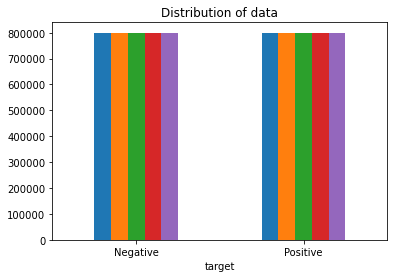

In [16]:
ax=df.groupby('target').count().plot(kind='bar',title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'],rotation=0)

<AxesSubplot:xlabel='target', ylabel='count'>

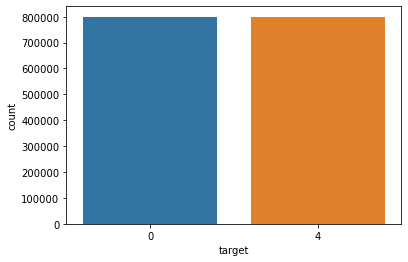

In [17]:
sns.countplot(x='target',data=df)

In [18]:
df.sample()

,target,ids,date,flag,user,text
583714,0,2215035353,Wed Jun 17 17:34:56 PDT 2009,NO_QUERY,ARutledge03,Just got home from the mall and dinner. Back t...


## Preprocessing the data 

In [19]:
dataset=df[['text','target']]

### Replacing the positive labels marked as '4' with '1'

In [20]:
dataset['target'] = dataset['target'].replace(4,1)
dataset.tail()

<ipython-input-20-fd9e47d3809a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['target'] = dataset['target'].replace(4,1)


,text,target
1599995,Just woke up. Having no school is the best fee...,1
1599996,TheWDB.com - Very cool to hear old Walt interv...,1
1599997,Are you ready for your MoJo Makeover? Ask me f...,1
1599998,Happy 38th Birthday to my boo of alll time!!! ...,1
1599999,happy #charitytuesday @theNSPCC @SparksCharity...,1


### Converting the data into lowercases

In [21]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

<ipython-input-21-cfdfd7510b56>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text']=dataset['text'].str.lower()


1599995    just woke up. having no school is the best fee...
1599996    thewdb.com - very cool to hear old walt interv...
1599997    are you ready for your mojo makeover? ask me f...
1599998    happy 38th birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @thenspcc @sparkscharity...
Name: text, dtype: object

### Removing the stopwords

In [22]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [23]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

<ipython-input-23-c1f31e612afa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))


0    @switchfoot http://twitpic.com/2y1zl - awww, t...
1    upset can't update facebook texting it... migh...
2    @kenichan dived many times ball. managed save ...
3                     whole body feels itchy like fire
4    @nationwideclass no, it's not behaving all. i'...
Name: text, dtype: object

### Removing punctuations

In [24]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

<ipython-input-24-8db2a3ff3a10>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))


1599995                  woke up no school best feeling ever
1599996    thewdbcom  cool hear old walt interviews ♫ htt...
1599997                      ready mojo makeover ask details
1599998    happy 38th birthday boo alll time tupac amaru ...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, dtype: object

### Removing repeating characters

In [25]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

<ipython-input-25-2587a2d701f4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))


1599995                  woke up no school best feeling ever
1599996    thewdbcom  cool hear old walt interviews ♫ htt...
1599997                      ready mojo makeover ask details
1599998    happy 38th birthday boo alll time tupac amaru ...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, dtype: object

### Removing URL's

In [26]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

<ipython-input-26-585aef627fe0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))


1599995                  woke up no school best feeling ever
1599996    thewdbcom  cool hear old walt interviews ♫ htt...
1599997                      ready mojo makeover ask details
1599998    happy 38th birthday boo alll time tupac amaru ...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, dtype: object

### Removing the numbers

In [27]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

<ipython-input-27-dccce35b8388>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))


1599995                  woke up no school best feeling ever
1599996    thewdbcom  cool hear old walt interviews ♫ htt...
1599997                      ready mojo makeover ask details
1599998    happy th birthday boo alll time tupac amaru sh...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, dtype: object

### Applying Tokenization

In [28]:
tokenizer = RegexpTokenizer('\s+', gaps=True)
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

<ipython-input-28-e78da8f47115>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(tokenizer.tokenize)


0    [switchfoot, httptwitpiccomzl, a, s, bummer, s...
1    [upset, cant, update, facebook, texting, it, m...
2    [kenichan, dived, many, times, ball, managed, ...
3              [whole, body, feels, itchy, like, fire]
4    [nationwideclass, no, its, not, behaving, all,...
Name: text, dtype: object

### Applying  Stemming

In [29]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()


<ipython-input-29-c0e7ddd070ca>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))


0    [switchfoot, httptwitpiccomzl, a, s, bummer, s...
1    [upset, cant, update, facebook, texting, it, m...
2    [kenichan, dived, many, times, ball, managed, ...
3              [whole, body, feels, itchy, like, fire]
4    [nationwideclass, no, its, not, behaving, all,...
Name: text, dtype: object

### Applying Lemmatization

In [30]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

<ipython-input-30-38fe06806eb8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))


0    [switchfoot, httptwitpiccomzl, a, s, bummer, s...
1    [upset, cant, update, facebook, texting, it, m...
2    [kenichan, dived, many, times, ball, managed, ...
3              [whole, body, feels, itchy, like, fire]
4    [nationwideclass, no, its, not, behaving, all,...
Name: text, dtype: object

### Creating the input and target variables

In [31]:
dataset['text']=[" ".join(text) for text in dataset['text'].values]
X = dataset['text']
y = dataset['target']

<ipython-input-31-42f2f8ecd9cd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text']=[" ".join(text) for text in dataset['text'].values]


### Plotting the word cloud

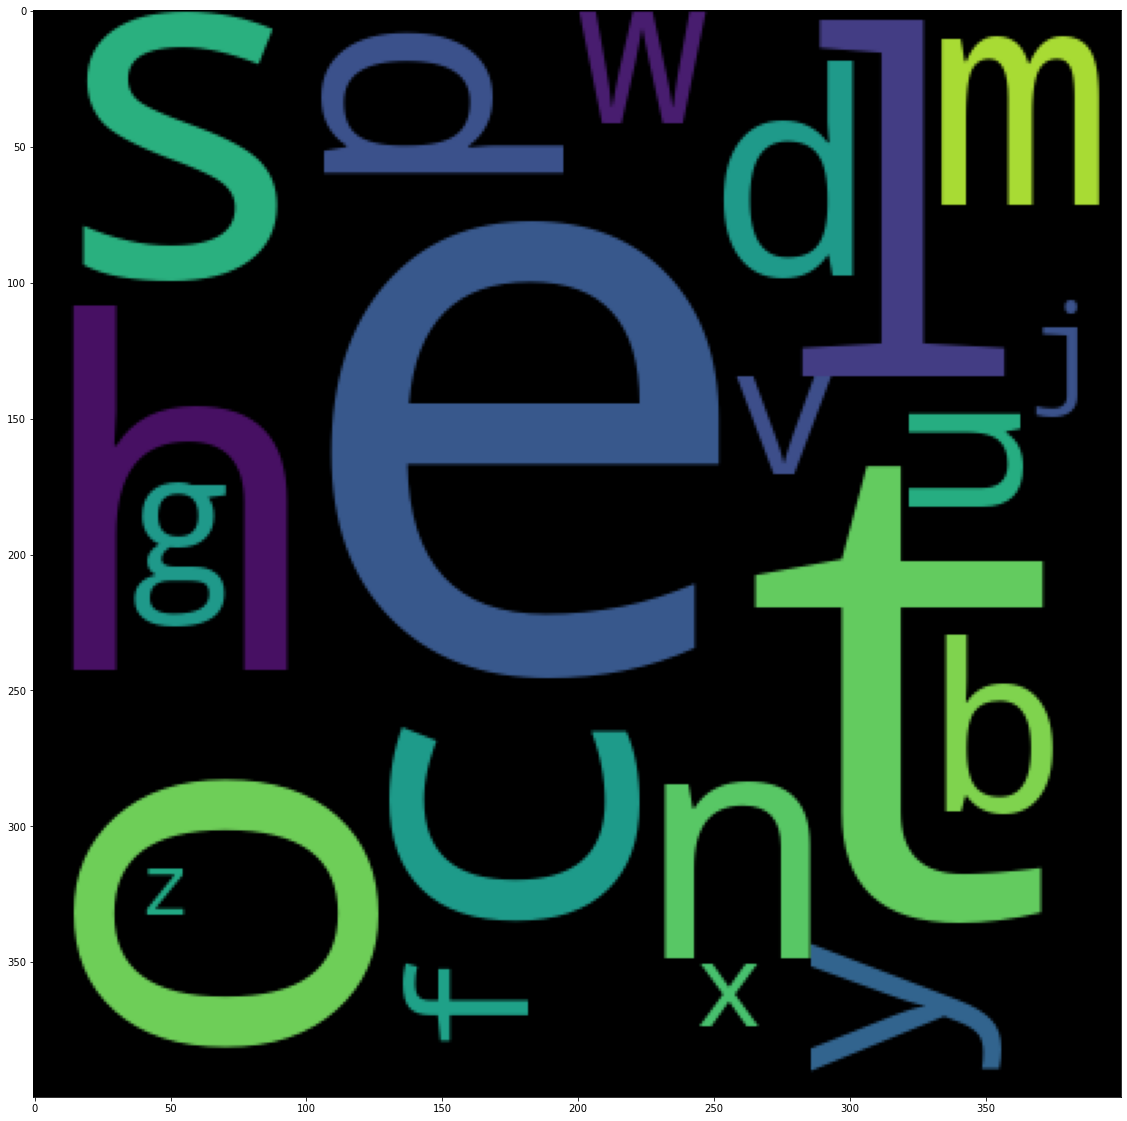

In [32]:
data_neg = dataset['text'][:300000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 500 , width = 400 , height = 400,
               collocations=False).generate(" ".join(str(X)))
plt.imshow(wc)

## Creating training and test set

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

## Transforming the training and testing sets using TF-IDF vectoriser

In [34]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)

In [35]:
X_train=vectoriser.fit_transform(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  500000


In [36]:
X_test=vectoriser.transform(X_test)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  500000


In [37]:
print(X_train)

  (0, 476702)	0.5437664148202004
  (0, 401025)	0.37617000378125126
  (0, 247286)	0.195055934905834
  (0, 476684)	0.36997103915811597
  (0, 378402)	0.3401995444142307
  (0, 269330)	0.4382190411046205
  (0, 301269)	0.18834242335911316
  (0, 400357)	0.21129197894853283
  (1, 367281)	0.4832186125214056
  (1, 465956)	0.32217370792281014
  (1, 116759)	0.28871888807220475
  (1, 208339)	0.2576177820691251
  (1, 388937)	0.31007948474830255
  (1, 326075)	0.2352349048156949
  (1, 366097)	0.18415597385140386
  (1, 465160)	0.18793123929786698
  (1, 345936)	0.5406126485328264
  (2, 72999)	0.3263612469333871
  (2, 218637)	0.368823782193659
  (2, 305453)	0.3312967033734614
  (2, 397727)	0.35971545679133093
  (2, 218711)	0.3252561928778243
  (2, 240814)	0.11963876624557696
  (2, 72874)	0.17049587992768744
  (2, 240120)	0.23031179437736615
  :	:
  (1519998, 299414)	0.4528784017428315
  (1519998, 325239)	0.297348835573931
  (1519998, 299390)	0.20192440080161614
  (1519998, 14164)	0.5114392632379097
  (15

## Function for Evaluating the Model

In [38]:
def model_Evaluate(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## Testing the model

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     40100
           1       0.81      0.83      0.82     39900

    accuracy                           0.81     80000
   macro avg       0.81      0.81      0.81     80000
weighted avg       0.81      0.81      0.81     80000



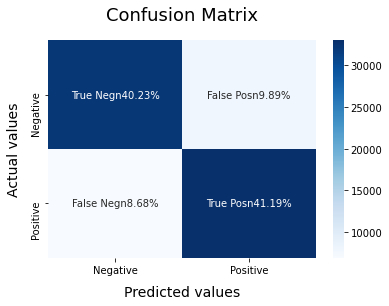

In [39]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)